# Evaluation and comparison of Adaptive median filter for impulse noise removal

In [27]:
#from __future__ import division # uncomment this if using Python 2.7
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from skimage import draw as drw
from skimage import data, color, exposure, img_as_float, img_as_ubyte, filters, morphology, io
import math
import random
import statistics
from google.colab import drive
import cv2
from scipy import ndimage
%matplotlib inline

# Necessary Functions:
pre processing the image: float function, reducing channels to gray only, adding salt and pepper noise

In [15]:
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
def my_uint2float(img):
    return ((1/255.)*img) 

def my_rgb2gray(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    Y = 0.3*R + 0.59*G + 0.11*B 
    Y=my_uint2float(Y)
    return Y

In [17]:
def add_sp(img,perc,ntype,mu,sigma):
    """ add salt and pepper noise to the input image """
    n , m= img.shape #need to be n , m , d if RGB
    noisenum = math.floor(n*m*perc/100)
    noiseg=np.zeros((np.shape(img)))
    noiseg=np.random.normal(mu,sigma)
    for i in range (0,noisenum):
        nn = np.random.randint(n)
        mm = np.random.randint(m)
        if ntype=='SP':
            img[nn,mm] = random.choice([0,1])
        if ntype=='RV':
            img[nn,mm] = np.random.randint(0,255)
    if ntype=='G':
        img = img+noiseg
        np.where(img>255, 255,img)
    return img

# Implementation of Adaptive Median Filter:
This algorithm is a two phase method. First of which is to determine if the window size is appropriate in terms of having a meaningfull content (Level A). It is done by the use of median, max and min values of the filter region. If the characteristics of the region is acceptable and it's median is not a noise, We can go to phase B, If not, the weindow size keeps increasing
The second phase (Level B) is to check if the point is contaminated or not. and according to this, the result would be either the point itself, or the median value.
The challenge here is when the window size increses, but we are window's center point is already a point located at the borders of the image. so the padding can not help. In this case only, I avoided increasing the window size.

In [18]:
def levelA(Z,i,j,winsize,Smax):
    row,col=np.shape(Z)
    N=Z[i-winsize:i+winsize+1,j-winsize:j+winsize+1]
    #print(N)
    neighbors=N.ravel()
    #print(neighbors)
    Zmed=statistics.median(neighbors)
    Zmin=min(neighbors)
    Zmax=max(neighbors)
    if Zmin<Zmed and Zmed<Zmax: #med is not a noise, we can count on it
        return(levelB(Z,i,j,Zmax,Zmin,Zmed))
    else:
        winsize=winsize+1
        if winsize<Smax:
            #check if after increasing the size of kernel, the padding is again necessary:
            #i,j should always be greater than or equal to winsize
            #winsize should always be less than or equal to l
            if winsize>i or winsize>row-i-1 or winsize>j or winsize>col-j-1: 
                return Z[i,j]
            return (levelA(Z,i,j,winsize,Smax))
        else:
            return Z[i,j]  

In [19]:
def levelB(Z,x,y,Zmax,Zmin,Zmed):
    if (Zmin<Z[x,y]) and (Z[x,y]<Zmax): #point is not a noise itself
        return Z[x,y]
    else:
        return Zmed

# my_Adaptive Median Filter

In [20]:
def my_amf(noisyimg,winsize,Smax):
    #ADAPTIVE ME 
    winsizeorg=winsize
    #kernel=(2*winsize+1)**2
    row,col=np.shape(noisyimg)
    imgamf=noisyimg
    imgamf=np.pad(noisyimg,(winsize,winsize),'symmetric') #padding
    row,col=np.shape(imgamf)
    for i in range(winsize,row-winsize):
        for j in range(winsize,col-winsize): #for each pixel
            imgamf[i,j]=levelA(imgamf,i,j,winsize,Smax)
            winsize=winsizeorg
        #cropping to obtain the original image size:)
    rr=len(imgamf)
    cc=len(imgamf[0])
    amf=imgamf[winsize:rr-winsize,winsize:cc-winsize]
    return amf

# Median filter
from scipy.ndimage sub module:

In [21]:
def median_filter(noisyimg,winsize):
    winsize=1
    mask=2*winsize+1
    smf = ndimage.median_filter(noisyimg, size=mask) #produces a mask*mask size kernel
    return smf

# Performance Comparison
comparing SMF with AMF:
Mean Square Error, Peak Signal to Noise Ratio, Image Enhancement Factor, and Correlation Ratio

In [ ]:
def evaluation(img,noisyimg,amf,smf):
    #Calculating Mean Square Error:
    gray=my_rgb2gray(img)
    MSE1=np.mean((amf-gray)**2)
    MSE2=np.mean((smf-gray)**2)
    #print("MSE of Adaptive Median Filter is {}, and that of SMF is {} ".format(MSE1,MSE2))
    #Calculating Peak Signal to Noise Ratio
    PSNR1=20*math.log10(255/np.sqrt(MSE1))
    PSNR2=20*math.log10(255/np.sqrt(MSE2))
    #print("PSNR of Adaptive Median Filter is {}, and that of SMF is {} ".format(PSNR1,PSNR2))
    #Calculating Image Enhancement Factor:
    IEF1=np.mean((noisyimg-gray)**2)/np.mean((amf-gray)**2)
    IEF2=np.mean((noisyimg-gray)**2)/np.mean((smf-gray)**2)
    #print('IEF of Adaptive Median Filter is {}, and that of SMF is {}'.format(IEF1,IEF2))
    # Calculating Correlation Ratio:
    diforg=gray-np.mean(gray)
    difamf=amf-np.mean(amf)
    difsmf=amf-np.mean(smf)
    CORR1=np.mean(diforg*difamf) / np.sqrt(np.mean((diforg**2)*(difamf**2)))
    CORR2=np.mean(diforg*difsmf) / np.sqrt(np.mean((diforg**2)*(difsmf**2)))
    #print('CORR of Adaptive Median Filter is {}, and that of SMF is {}'.format(CORR1,CORR2))
    return MSE1,MSE2,PSNR1,PSNR2,IEF1,IEF2,CORR1,CORR2

## Noise% explore
Reading Image and turning it to grayscle, then adding noise. Then the AMF is called for different noise values to compare the results in terms of mathematical evaluation and visual quality as well

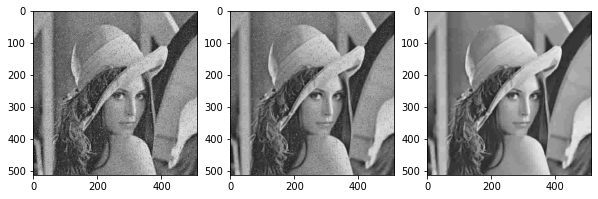

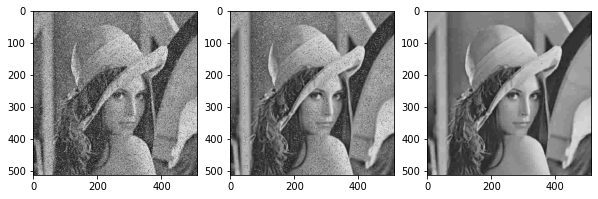

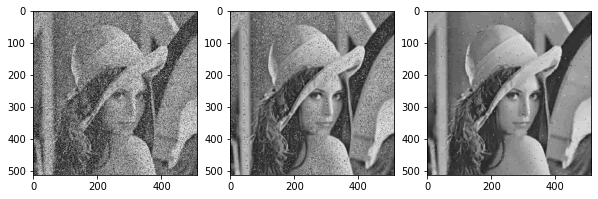

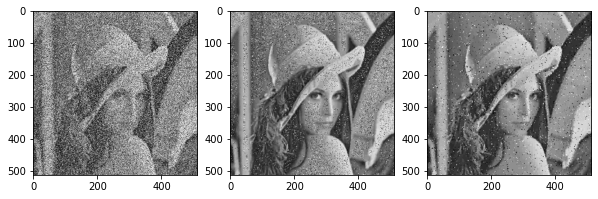

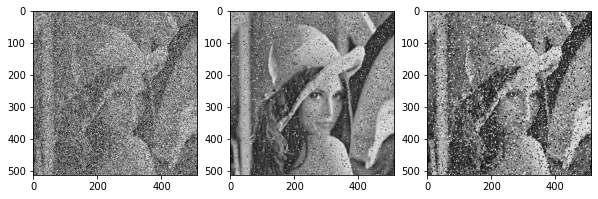

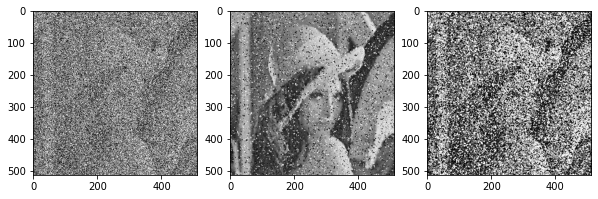

In [29]:
img=io.imread('/content/drive/MyDrive/Colab Notebooks/lena5.jpeg')
gimg=my_rgb2gray(img)

percentage=np.array([5,10,15,20,40,60])
MSE1=np.zeros((len(percentage)))
MSE2=np.zeros((len(percentage)))
PSNR1=np.zeros((len(percentage)))
PSNR2=np.zeros((len(percentage)))
IEF1=np.zeros((len(percentage)))
IEF2=np.zeros((len(percentage)))
CORR1=np.zeros((len(percentage)))
CORR2=np.zeros((len(percentage)))
for n in range(len(percentage)):
    fig=plt.figure(figsize=[10,15])
    
    noisyimg=add_sp(gimg,percentage[n],'SP',0,0)
    a1=fig.add_subplot(131)
    a1.imshow(noisyimg,cmap='gray')
    
    windowsize=1 #To have same condition for both algorithms
    Smax=1
    amf=my_amf(noisyimg,windowsize,Smax)
    a2=fig.add_subplot(132)
    a2.imshow(amf,cmap='gray')
    
    smf=median_filter(noisyimg,windowsize)
    a3=fig.add_subplot(133)
    a3.imshow(smf,cmap='gray')
    
    MSE1[n],MSE2[n],PSNR1[n],PSNR2[n],IEF1[n],IEF2[n],CORR1[n],CORR2[n]=evaluation(img,noisyimg,amf,smf)

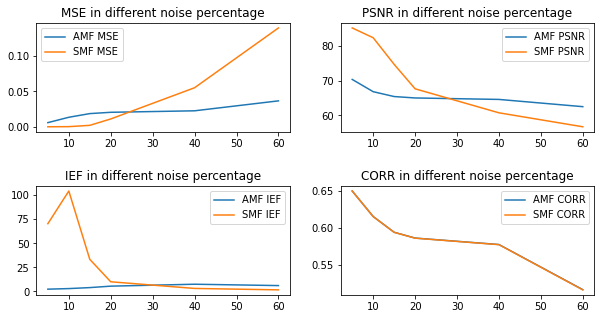

In [30]:
fig=plt.figure(figsize=[10,5])
a1=fig.add_subplot(221)
a1.plot(percentage,MSE1,label="AMF MSE")
a1.plot(percentage,MSE2,label="SMF MSE")
a1.set_title('MSE in different noise percentage')
a1.legend()
a2=fig.add_subplot(222)
a2.plot(percentage,PSNR1,label="AMF PSNR")
a2.plot(percentage,PSNR2,label="SMF PSNR")
a2.set_title('PSNR in different noise percentage')
a2.legend()
a3=fig.add_subplot(223)
a3.plot(percentage,IEF1,label="AMF IEF")
a3.plot(percentage,IEF2,label="SMF IEF")
a3.set_title('IEF in different noise percentage')
a3.legend()
a4=fig.add_subplot(224)
a4.plot(percentage,CORR1, label="AMF CORR")
a4.plot(percentage,CORR2,label="SMF CORR")
a4.set_title('CORR in different noise percentage')
a4.legend()
fig.subplots_adjust(hspace=0.5)

### Observing the PSNR while growing window size threshold:
setting winsize to a great number won't help!
Only a slight change in PSNR when noise density is high

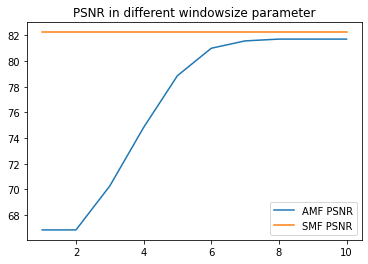

In [33]:
img=io.imread('/content/drive/MyDrive/Colab Notebooks/lena5.jpeg')
gimg=my_rgb2gray(img)
noisyimg=add_sp(gimg,15,'SP',0,0) #noise percentage fix
#we set window size of SMF to this threshold so that it would be comparable
Smax=np.array([1,2,3,4,5,6,7,8,10])
MSE1=np.zeros((len(Smax)))
MSE2=np.zeros((len(Smax)))
PSNR1=np.zeros((len(Smax)))
PSNR2=np.zeros((len(Smax)))
IEF1=np.zeros((len(Smax)))
IEF2=np.zeros((len(Smax)))
CORR1=np.zeros((len(Smax)))
CORR2=np.zeros((len(Smax)))
for s in range(len(Smax)):
    
    windowsize=1 #begin with 1 
    amf=my_amf(noisyimg,windowsize,Smax[s])
    smf=median_filter(noisyimg,Smax[s]) #pass the maximum winsize of AMF as fixed winsize
    
    MSE1[s],MSE2[s],PSNR1[s],PSNR2[s],IEF1[s],IEF2[s],CORR1[s],CORR2[s]=evaluation(img,noisyimg,amf,smf)

plt.plot(Smax,PSNR1,label="AMF PSNR")
plt.plot(Smax,PSNR2,label="SMF PSNR")
plt.title('PSNR in different windowsize parameter')
plt.legend()

### How the AMF responds to noises other than SP, namely another impulse(random value), and gaussian
Claim: The adaptive median filter does not perform as well as SMF on other types of noise

PSNR of AMF for Random Value noise is 5.693132391545054, and that of SMF is 5.727844373698079 
PSNR of AMF for Gaussian noise is 5.6796068628111644, and that of SMF is 5.714214679031061 


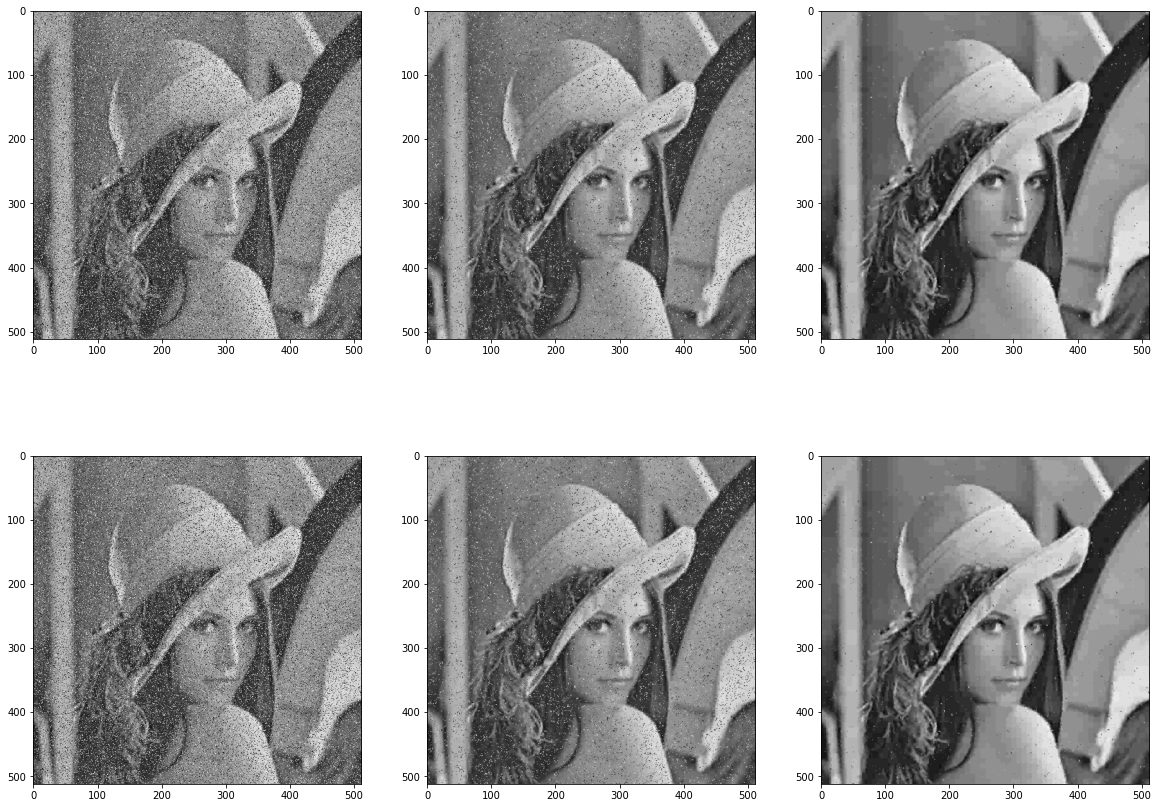

In [35]:
img=io.imread('/content/drive/MyDrive/Colab Notebooks/lena5.jpeg')
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
gimg = 0.3*R + 0.59*G + 0.11*B #not float image

fig=plt.figure(figsize=[20,15])

#..................................................Random Value noise....................................................

noisyimg=add_sp(gimg,30,'RV',0,0)
a1=fig.add_subplot(231)
a1.imshow(noisyimg,cmap='gray')
   
windowsize=1 #To have same condition for both algorithms
Smax=3
amf=my_amf(noisyimg,windowsize,Smax)
a2=fig.add_subplot(232)
a2.imshow(amf,cmap='gray')
  
smf=median_filter(noisyimg,windowsize)
a3=fig.add_subplot(233)
a3.imshow(smf,cmap='gray')

MSE1,MSE2,PSNR1,PSNR2,IEF1,IEF2,CORR1,CORR2=evaluation(img,noisyimg,amf,smf)
print("PSNR of AMF for Random Value noise is {}, and that of SMF is {} ".format(PSNR1,PSNR2))
#..................................................Gaussian noise....................................................

noisyimg=add_sp(gimg,15,'G',0,1)
a4=fig.add_subplot(234)
a4.imshow(noisyimg,cmap='gray')
   
windowsize=1 #To have same condition for both algorithms
Smax=3
amf=my_amf(noisyimg,windowsize,Smax)
a5=fig.add_subplot(235)
a5.imshow(amf,cmap='gray')
  
smf=median_filter(noisyimg,windowsize)
a6=fig.add_subplot(236)
a6.imshow(smf,cmap='gray')
MSE1,MSE2,PSNR1,PSNR2,IEF1,IEF2,CORR1,CORR2=evaluation(img,noisyimg,amf,smf)
print("PSNR of AMF for Gaussian noise is {}, and that of SMF is {} ".format(PSNR1,PSNR2))